In [1]:
from keras import applications, optimizers
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Sequential
from keras.datasets import mnist
from keras.layers.convolutional import Convolution2D
from keras import backend as K
import keras
import numpy as np
from keras.applications.imagenet_utils import preprocess_input
from img_loader import DatasetLoader
from keras.utils import np_utils
from keras.preprocessing import image
from keras.models import Model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageOps
from sklearn.preprocessing import MinMaxScaler
import scipy.misc
from PIL import ImageEnhance
import cv2
import matplotlib.pyplot as pp
from keras.models import load_model, save_model
import random
from numpy import argmax
from scipy.misc import toimage

Using TensorFlow backend.


In [2]:
%matplotlib inline
np.random.seed(123)  # for reproducibility
random.seed(123)

In [3]:
dl = DatasetLoader('/home/lux/dev/Bachelor-2017/keras/dataset', 10000)

DATASET LOADER] Discovering dataset...
DATASET LOADER] 
38 classes found.
 54305 images found.
DATASET LOADER] Shuffling order...
DATASET LOADER] 
Ready for loading!
 40728 for training and 13576 for testing


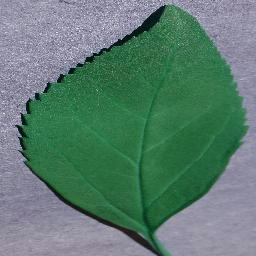

In [4]:
i = 0
img = cv2.imread(dl.baseDirectory + "/" + dl.imgDataArray[i].directory + "/" +
                                       dl.imgDataArray[i].name, cv2.IMREAD_COLOR)
i = 1
img2 = cv2.imread(dl.baseDirectory + "/" + dl.imgDataArray[i].directory + "/" +
                                       dl.imgDataArray[i].name, cv2.IMREAD_COLOR)
img = img.astype('float32')
toimage(img)

In [5]:
model = load_model("/home/lux/Dropbox/HEIG/BACHELOR-2017-SAFE/vgg16_ft_cam_normal.h5")

/usr/lib64/python3.5/site-packages/keras/models.py:281: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


In [6]:
np.asarray(model.get_layer("W").get_weights()).shape

(2,)

In [11]:
def get_outputs_generator(model, layer_name):
    """
    Gets the output generator of a specific layer of the model.

    :param model: The model
    :param layer_name: The layer's name
    :return: the output generator (a function)
    """
    layer_model = Model(
        input=model.input,
        output=model.get_layer(layer_name).output
    )

    return layer_model.predict

def heatmap_generate(input_img, model, class_to_predict, layer_name, image_name=None):
   
    output_generator = get_outputs_generator(model, layer_name)
    layer_outputs = output_generator(np.expand_dims(input_img, axis=0))[0]
    
    heatmap = cv2.resize(layer_outputs[:, :, 0], (224, 224), interpolation=cv2.INTER_CUBIC)
    
    w = model.get_layer("W").get_weights()[0]
    heatmap *= w[0][class_to_predict]

    for z in range(1, layer_outputs.shape[2]): # Iterate through the number of kernels
        img = layer_outputs[:, :, z]

        deprocessed = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)
        heatmap += deprocessed * w[z][class_to_predict]

    return heatmap

In [12]:
predict_input = np.expand_dims(img, axis=0)
predict_input = predict_input.astype('float32')
predict_input = preprocess_input(predict_input)
predict_input.shape[1:3]

(256, 256)

In [13]:
argmax(model.predict(predict_input))

6

/usr/lib/python3.5/site-packages/ipykernel/__main__.py:11: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("CA...)`


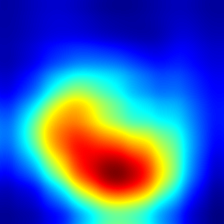

In [14]:
heatmap = heatmap_generate(predict_input[0], model, argmax(model.predict(predict_input)), 'CAM')
from scipy.misc import toimage
toimage(cv2.applyColorMap(np.uint8(np.asarray(ImageOps.invert(toimage(heatmap)))), cv2.COLORMAP_JET))